# Using Transition Matrix Methods under IndShockConsumerType 

By William Du (wdu9@jhu.edu)

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices with functions under the IndShockConsumerType.

The three key functions to non stochastically simulate are:

##### define_distribution_grid
- computes the grid of normalized market resources and the grid permanent income storing each as attributes of self.

###### calc_transition_matrix 
- computes transition matrix (matrices), a grid of consumption policies, and a grid asset policies stored as attributes of self. If the problem has a finite horizon, this function stores lists of transition matrices, consumption policies and asset policies grid for each period as attributes of self.

##### calc_ergodic_dist 
- computes the ergodic distribution stored as attributes. The distribution is stored as a vector (self.vec_erg_dstn) and as a grid (self.erg_dstn)



## Set up Computational Environment

In [1]:

from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType


import time
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt

import time


## Set up the Dictionary

In [2]:

Dict={
    # Parameters shared with the perfect foresight model
    "CRRA":2,                             # Coefficient of relative risk aversion
    "Rfree": 1.04**.25,                   # Interest factor on assets
    "DiscFac": 0.975,                     # Intertemporal discount factor
    "LivPrb" : [.99375],                  # Survival probability
    "PermGroFac" :[1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" :  [.06],                 # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.00,                     # Probability of unemployment while working
    "IncUnemp" :  .0,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 98000,                 # Number of agents of this type
    "T_sim" : 1100,                       # Number of periods to simulate
    "aNrmInitMean" :np.log(0.0),# Mean of log initial assets , 
    # The value of np.log(0.0) causes the code to ensure newborns have have exactly 1.0 in market resources.
    
    # Mean of log initial assets
    "aNrmInitStd"  : 0.0,                 # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 90,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
     }


C:\Users\wdu\AppData\Local\Temp\ipykernel_18772\4112512667.py:30: RuntimeWarning: divide by zero encountered in log
  "aNrmInitMean" :np.log(0.0),# Mean of log initial assets ,


## Create an Instance of IndShockConsumerType and Solve

In [3]:

example1 = IndShockConsumerType(**Dict)
example1.cycles = 0
example1.solve()

GPFRaw                 = 0.992274 
GPFNrm                 = 0.995482 
GPFAggLivPrb           = 0.986072 
Thorn = APF            = 0.992274 
PermGroFacAdj          = 0.996777 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.965783 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.983869 
DiscFacGPFAggLivPrbMax = 0.996471 


# Simulation: Transition Matrix vs Monte Carlo

This section compares monte carlo methods against the transition matrix approach in computing aggregate consumption and aggregate assets.

## Method 1: Monte Carlo 

In [4]:

# Simulation Parameters 

#Simulate
example1.track_vars = ['aLvl'] # Track level of assets
example1.initialize_sim()
example1.simulate() #Simulate with Monte Carlo

#Compute Aggregate Consumption and Aggregate Assets
Monte_Carlo_Consumption = np.mean((example1.state_now['mNrm'] - example1.state_now['aNrm'])*example1.state_now['pLvl']) #Aggregate Consumption
Monte_Carlo_Assets = np.mean(example1.state_now['aNrm']*example1.state_now['pLvl']) #Aggregate Assets


## Method 2: Transition Matrices

In [5]:

example1.define_distribution_grid(num_pointsP = 70,timestonest = 3)
p = example1.dist_pGrid # Grid of permanent income levels

start = time.time()

example1.calc_transition_matrix()
c = example1.cPol_Grid # Normalized Consumption Policy Grid
asset = example1.aPol_Grid # Normalized Asset Policy Grid

example1.calc_ergodic_dist()
vecDstn = example1.vec_erg_dstn # Distribution of market resources and permanent income as a vector (m*p)x1 vector where 
# m is the number of market resource gridpoints and p is the number of permanent income gridpoints
erg_dstn=example1.erg_dstn

print('Seconds to calculate both the transition matrix and the steady state distribution', time.time() - start)


Seconds to calculate both the transition matrix and the steady state distribution 30.002366304397583


In [6]:

#Compute Aggregate Consumption and Aggregate Assets
gridc = np.zeros( (len(c),len(p)) )
grida = np.zeros( (len(asset),len(p)) )

for j in range(len(p)):
    gridc[:,j] = p[j]*c # unnormalized Consumption policy grid
    grida[:,j] = p[j]*asset # unnormalized Asset policy grid
    
AggC = np.dot(gridc.flatten(), vecDstn) #Aggregate Consumption
AggA = np.dot(grida.flatten(), vecDstn) #Aggregate Assets


### Comparing Steady State Outputs of Both Methods

In [7]:

print( 'TranMatrix Assets = ' + str(AggA) )
print('Simulated Assets = ' +str(Monte_Carlo_Assets) )

print('TranMatrix Consumption = ' + str(AggC))
print('Simulated Consumption = ' +str(Monte_Carlo_Consumption))


TranMatrix Assets = [0.41757072]
Simulated Assets = 0.4130000603138478
TranMatrix Consumption = [1.00147553]
Simulated Consumption = 1.0035239330448291


### Comparing Simulated Path of Aggregate Assets

The following code plots the path of aggregate assets simulate from both Monte Carlo methods and transition matrix methods.

In [8]:


aLvls =[] # Time series of aggregate assets

for i in range(example1.T_sim):
    aLvls.append(np.mean(example1.history['aLvl'][i])) #compute mean of aggregate assets across all agents for each period of the simulation
aLvls = np.array(aLvls)

aLvl_tran_mat = []
dstn = vecDstn
for i in range(example1.T_sim-400):

    A_val = np.dot(grida.flatten(),dstn) 
    
    aLvl_tran_mat.append(A_val)
    dstn = np.dot( example1.tran_matrix,dstn)




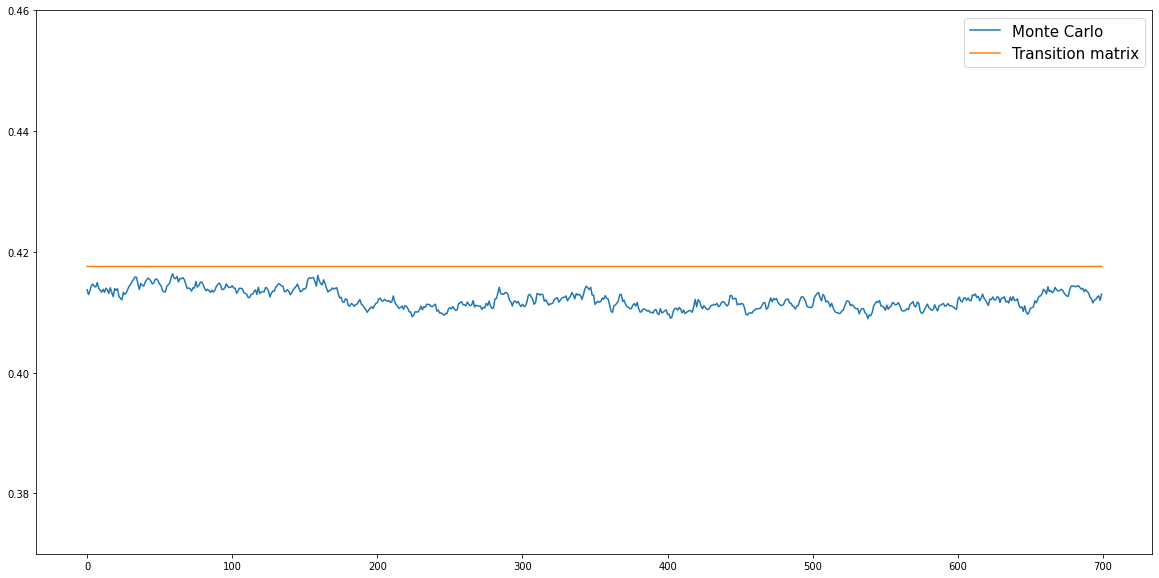

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(aLvls[400:], label = 'Monte Carlo') # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.plot(aLvl_tran_mat , label = 'Transition matrix') # Plot time series path of aggregate assets computed using transition matrix
plt.legend(prop={'size': 15})
plt.ylim([.37,.46])
plt.show()


### Precision vs Accuracy

Notice the mean level of aggregate assets differ between both simulation methods. The transition matrix plots a perfectly horizontal line as the initial distribution of agents across market resources and permanent is the unit eigenvector of the steady state transition matrix. Thus, as we take the produce of the transition matrix and the initial distribution, the new distribution does not change, implying the level of aggregate assets does not change. In contrast, the time series path simulated from Monte Carlo methods vacillates. This is because Monte Carlo methods are truly stochastic, randomly drawing shocks from a income distribution, while transition matrix methods are non-stochastic, the shock values are preset and the grid over market resources have is fixed. This contrast highlights the limitation of both methods, the monte carlo leads to a more accurate, yet less precise, level of aggregate assets while the transition matrix leads in precision but requires a larger number of gridpoints to be accurate. 

## Distribution of Normalized Market Resources

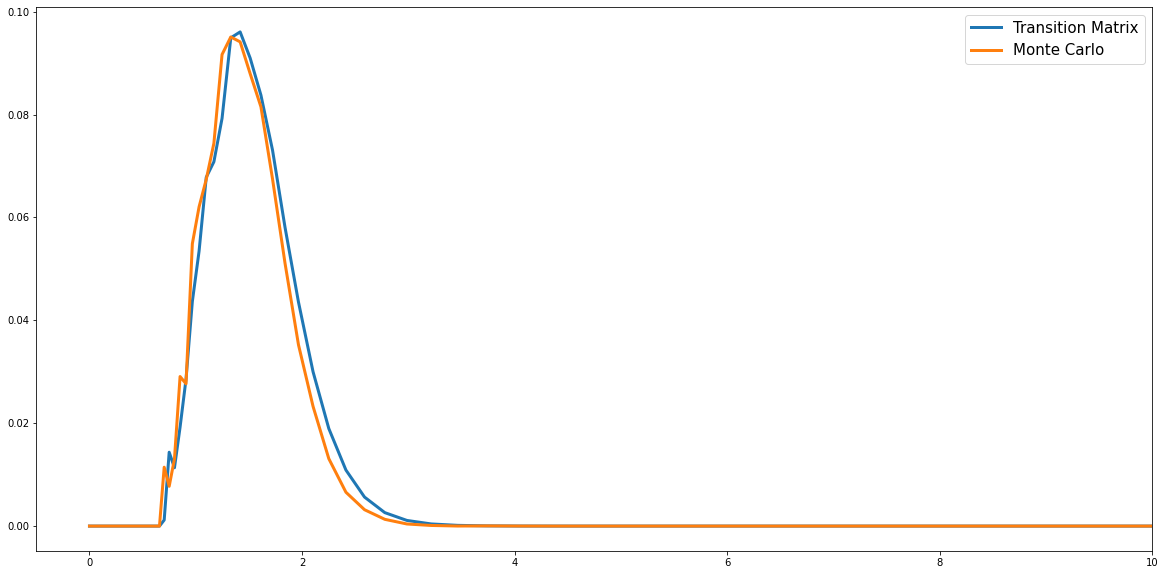

In [10]:

num_pts = len(example1.dist_mGrid)
mdstn = np.zeros(num_pts) 

for i in range(num_pts):
    mdstn[i] = np.sum(example1.erg_dstn[i]) #distribution of normalized market resources

h = np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]/np.sum(np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins


plt.plot(example1.dist_mGrid[:num_pts - 20],mdstn[:num_pts-20],label='Transition Matrix', linewidth = 3.0) # distribution using transition matrix method 
plt.plot(example1.dist_mGrid[:num_pts-20-1],h[:num_pts-20-1] , label = 'Monte Carlo', linewidth = 3.0) #distribution using Monte Carlo
plt.legend(prop={'size': 15})
plt.xlim([-.5,10])
plt.show()


## Distributions of Permanent Income 

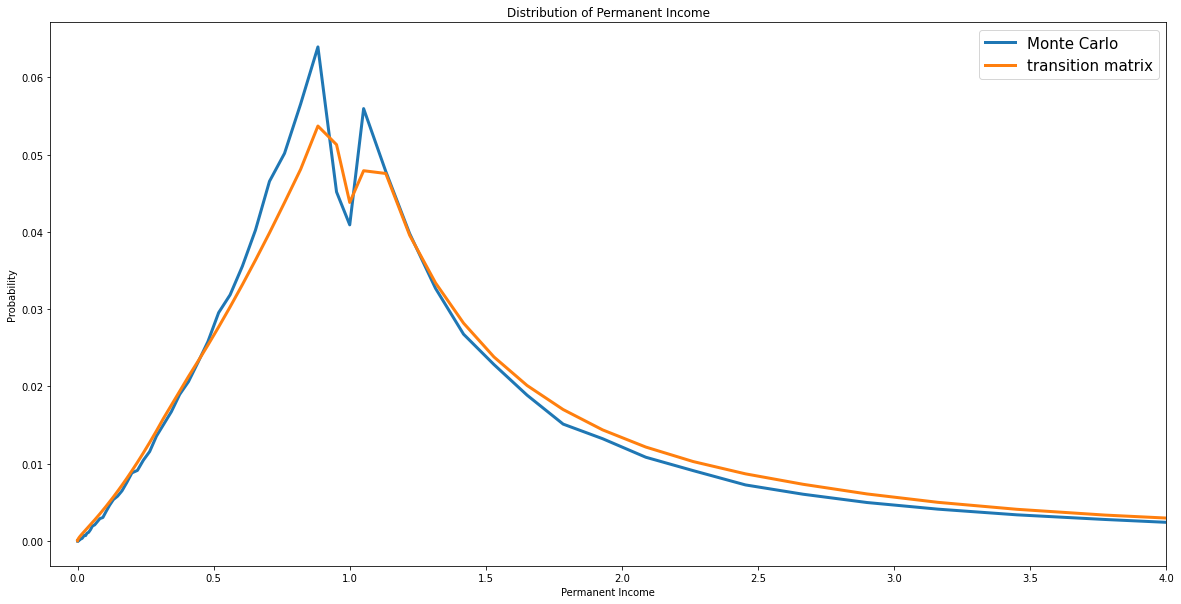

In [11]:

dstn = example1.erg_dstn

pdstn = np.zeros(len(dstn[0]))
for i in range(len(pdstn)):
    pdstn[i] = np.sum(dstn[:,i])
    
h = np.histogram(example1.state_now['pLvl'],bins=example1.dist_pGrid)[0]/np.sum(np.histogram(example1.state_now['pLvl'],bins=example1.dist_pGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins
plt.plot(example1.dist_pGrid[:-1],h,label='Monte Carlo', linewidth = 3.0) #distribution using Monte Carlo
plt.plot(example1.dist_pGrid,pdstn , label = 'transition matrix', linewidth = 3.0)
plt.ylabel('Probability')
plt.xlabel('Permanent Income')
plt.title('Distribution of Permanent Income')
plt.legend(prop={'size': 15})
plt.xlim([-.1,4])
plt.show()


## Distribution of Wealth 

In [12]:
#Compute all possible mLvl values given permanent income grid and normalized market resources grid

mLvl_vals = []

for m in example1.dist_mGrid:
        
    for p in example1.dist_pGrid:
        
        mLvl_vals.append(m*p)

mLvl_vals = np.array(mLvl_vals)



aLvl_vals = []

for a in example1.aPol_Grid:
        
    for p in example1.dist_pGrid:
        
        aLvl_vals.append(a*p)

aLvl_vals = np.array(aLvl_vals)
        

In [13]:
def jump_to_grid_fast(m_vals, probs ,Dist_mGrid ):
    
    '''
    Distributes values onto a predefined grid, maintaining the means.
    
    
    Parameters
    ----------
    m_vals: np.array
            Market resource values 

    probs: np.array
            Shock probabilities associated with combinations of m_vals. 
            Can be thought of as the probability mass function  of (m_vals).
    
    dist_mGrid : np.array
            Grid over normalized market resources

    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources
  
    ''' 

    probGrid = np.zeros(len(Dist_mGrid))
    mIndex = np.digitize(m_vals,Dist_mGrid) - 1
    mIndex[m_vals <= Dist_mGrid[0]] = -1
    mIndex[m_vals >= Dist_mGrid[-1]] = len(Dist_mGrid)-1
    
 
    for i in range(len(m_vals)):
        if mIndex[i]==-1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(Dist_mGrid)-1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i]+1
            mlowerWeight = (Dist_mGrid[mupperIndex]-m_vals[i])/(Dist_mGrid[mupperIndex]-Dist_mGrid[mlowerIndex])
            mupperWeight = 1.0 - mlowerWeight
            
        probGrid[mlowerIndex] +=  probs[i]*mlowerWeight
        probGrid[mupperIndex] +=  probs[i]*mupperWeight
        
    return probGrid.flatten()


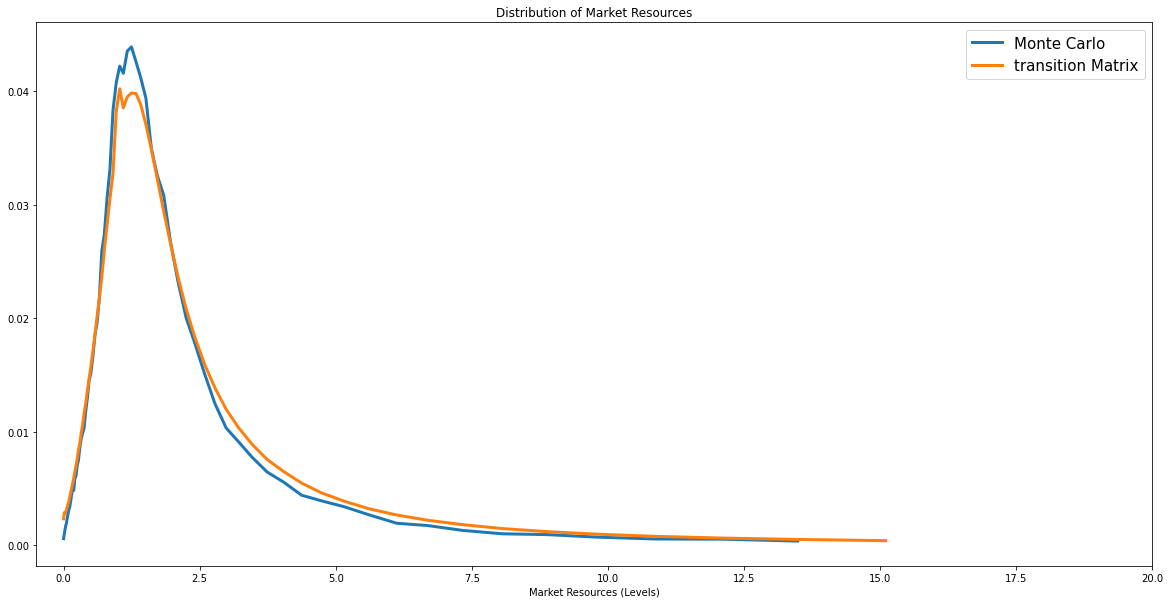

In [14]:

mLvl = example1.state_now['mNrm'] * example1.state_now['pLvl'] #market resources from Monte Carlo Simulations
pmf = jump_to_grid_fast(mLvl_vals, vecDstn, example1.dist_mGrid) # probabilities/distribution from transition matrix methods
h = np.histogram(mLvl,bins=example1.dist_mGrid)[0]/np.sum(np.histogram(mLvl,bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins

plt.plot(example1.dist_mGrid[:num_pts-20-1],h[:num_pts-20-1] , label = 'Monte Carlo', linewidth = 3.0) #distribution using Monte Carlo
plt.plot(example1.dist_mGrid[:num_pts-20],pmf[:num_pts-20], label = 'transition Matrix', linewidth = 3.0)
plt.xlabel('Market Resources (Levels)')
plt.title('Distribution of Market Resources')
plt.legend(prop={'size': 15})
plt.xlim([-.5,20])
plt.show()


## Distribution of Liquid Assets

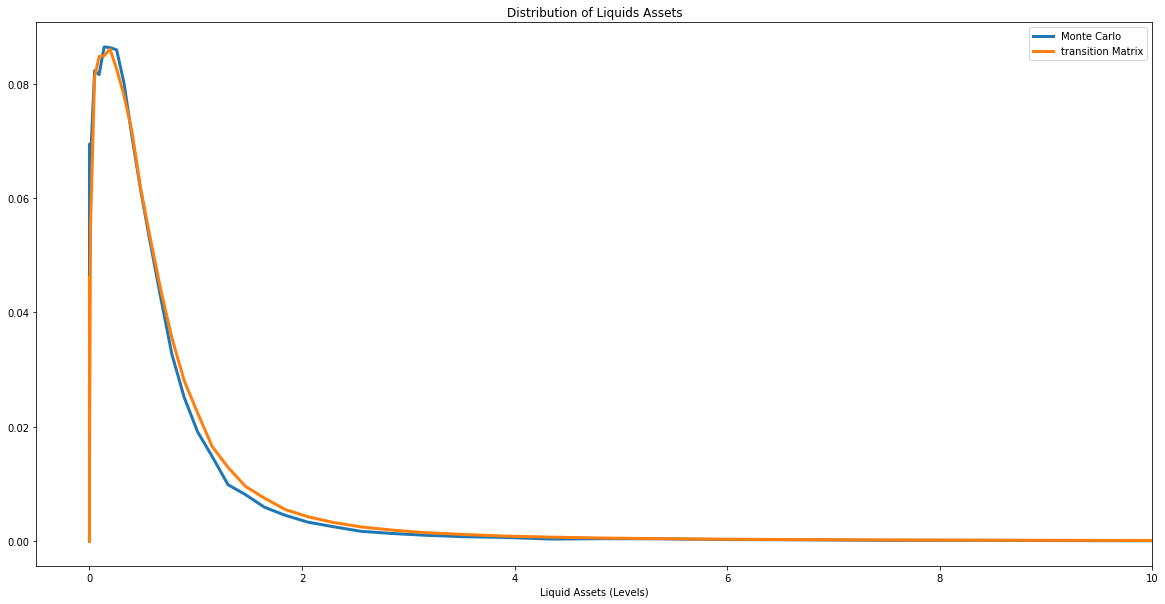

In [15]:

asset_Lvl = example1.state_now['aLvl']  #market resources from Monte Carlo Simulations
pmf = jump_to_grid_fast(aLvl_vals, vecDstn, example1.aPol_Grid) # probabilities/distribution from transition matrix methods
h = np.histogram(asset_Lvl,bins=example1.aPol_Grid)[0]/np.sum(np.histogram(asset_Lvl,bins=example1.aPol_Grid)[0]) #Form Monte Carlo wealth data and put into histogram/bins

plt.plot(example1.aPol_Grid[:num_pts-10-1],h[:num_pts-10-1] , label = 'Monte Carlo', linewidth = 3.0) #distribution using Monte Carlo
plt.plot(example1.aPol_Grid[:num_pts-10],pmf[:num_pts-10], label = 'transition Matrix', linewidth = 3.0)
plt.xlabel('Liquid Assets (Levels)')
plt.title('Distribution of Liquids Assets')
plt.legend()
plt.xlim([-.5,10])
plt.show()

# Calculating the Path of Consumption given an Perfect foresight MIT shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. In particular, in this experiment, in period t=0, agents learn that there will be a shock in the interest rate in period t=10. Given this, the simulated paths of aggregate consumption and aggregate assets will be computed and plotted. 



### Compute Steady State Distribution

We will want the simulation to begin at the economy's steady state. Therefore first we will compute the steady state distribution over market resources and permanent income. This will be the distribution for which the computed transition matrices will be applied/multiplied to. 

In [16]:

ss = IndShockConsumerType(**Dict)
ss.cycles = 0
ss.solve()


GPFRaw                 = 0.992274 
GPFNrm                 = 0.995482 
GPFAggLivPrb           = 0.986072 
Thorn = APF            = 0.992274 
PermGroFacAdj          = 0.996777 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.965783 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.983869 
DiscFacGPFAggLivPrbMax = 0.996471 


## Simulating With Harmenberg (2021) Method

Harmenberg (2021) method may also be implemented when simulating with transition matrices. In the following cells, we compute the steady distribution using Harmenberg's method.

For more information on Harmenberg's Method to dramatically improve simulation times see https://econ-ark.org/materials/harmenberg-aggregation?launch



In [17]:

# Change the income process to use Neutral Measure
ss.neutral_measure = True 
ss.update_income_process()

ss.aXtraCount = 1000
ss.aXtraMax = 3000


In [18]:

# Set up grid and calculate steady state transition Matrices

start = time.time() 

ss.define_distribution_grid()
ss.calc_transition_matrix()

c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist() #Calculate steady state distribution
vecDstn_fast = ss.vec_erg_dstn #Distribution as a vector (mx1) where m is the number of gridpoint on the market resources grid

print('Seconds to calculate both the transition matrix and the steady state distribution with Harmenberg', time.time() - start)


AggA_fast =  np.dot(ss.aPol_Grid,vecDstn_fast)


Seconds to calculate both the transition matrix and the steady state distribution with Harmenberg 3.901898145675659


Computing the transition matrix and ergodic distribution with the harmenberg measure is significantly faster. (Note the number of gridpoints on the market resources grid is 1000 instead of 90.

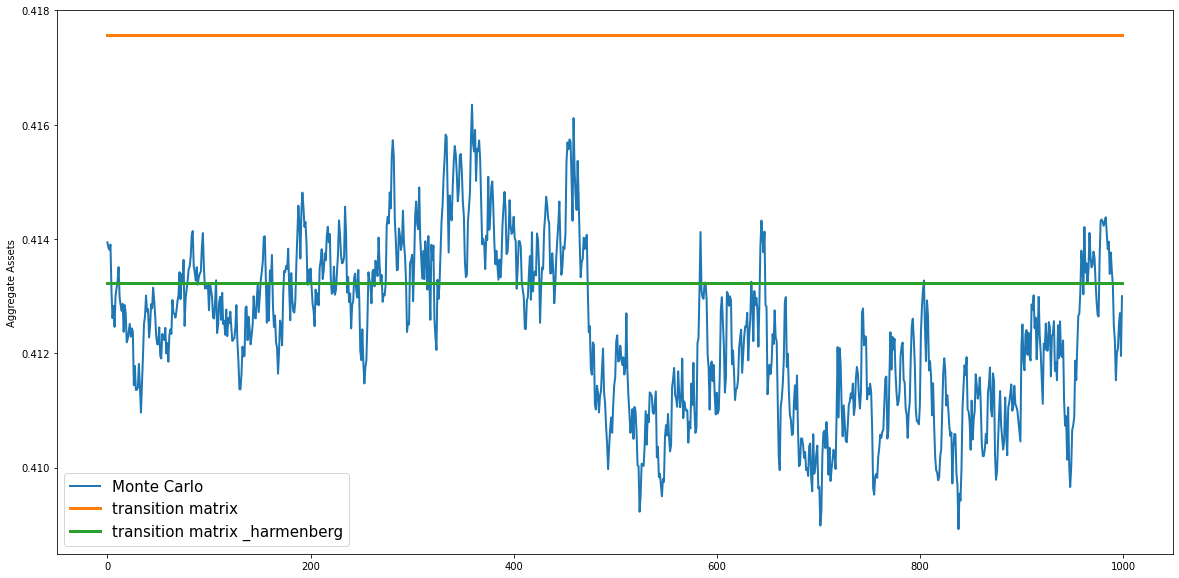

In [19]:


plt.plot(aLvls[100:], label = 'Monte Carlo', linewidth = 2.0) # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.plot(np.ones(example1.T_sim-100)*AggA , label = 'transition matrix', linewidth = 3.0) # Plot time series path of aggregate assets computed using transition matrix
plt.plot(np.ones(example1.T_sim-100)*AggA_fast , label = 'transition matrix _harmenberg', linewidth = 3.0) # Plot time series path of aggregate assets computed using transition matrix
plt.ylabel('Aggregate Assets')
plt.legend(prop={'size': 15})
plt.rcParams["figure.figsize"] = (20,10)
plt.show()


### Note* Increasing the number of gridpoints increases the accuracy of the transition matrix method

In [20]:
Agg_AVals = []

mpoints = [100,150,200,500,3000]
for i in mpoints:
    
    ss.aXtraCount = i
    
    ss.define_distribution_grid()
    ss.calc_transition_matrix()

    ss.calc_ergodic_dist() #Calculate steady state distribution
    vecDstn_fast = ss.vec_erg_dstn #Distribution as a vector (mx1) where m is the number of gridpoint on the market resources grid
    Asset_val = np.dot(ss.aPol_Grid,vecDstn_fast)

    Agg_AVals.append(Asset_val)
    
    

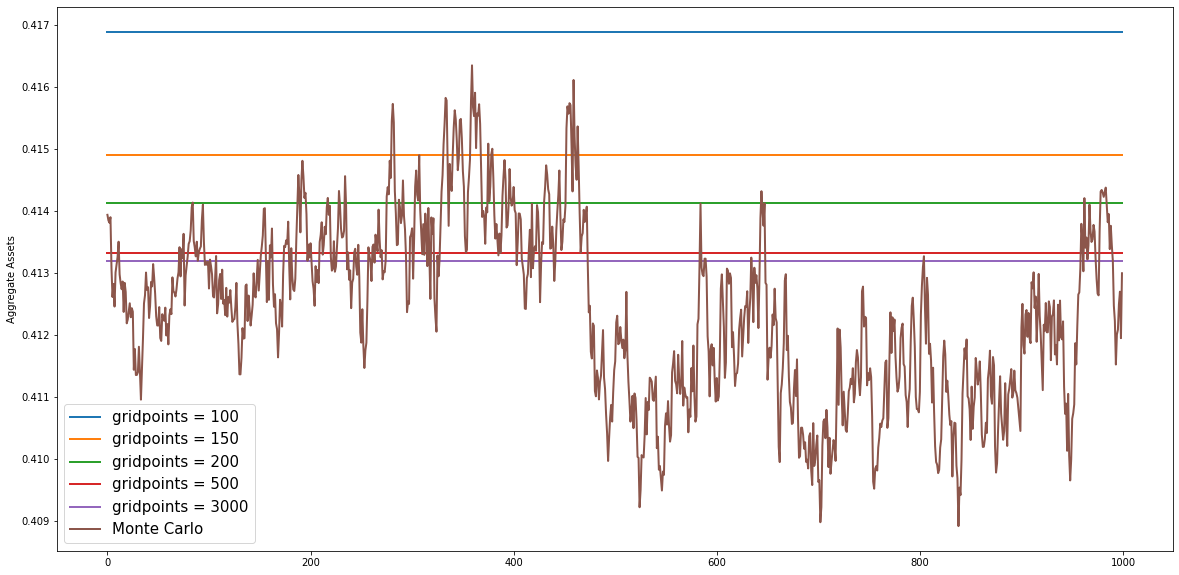

In [21]:
for i in range(len(Agg_AVals)):
    
    plt.plot(np.ones(example1.T_sim-100)*Agg_AVals[i], label = 'gridpoints = ' + str(mpoints[i]), linewidth = 2.0)

plt.plot(aLvls[100:], label = 'Monte Carlo', linewidth = 2.0) # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.ylabel('Aggregate Assets')
plt.legend(prop={'size': 15})
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

Note the Harmenberg method not only reduces the time of computation but also improves the accuracy of the simulated path of assets. 

### Monte Carlo Simulation with Harmenberg Trick

In [22]:

ss.AgentCount = 25000
ss.T_sim = 700
ss.initialize_sim()
ss.simulate()


{}

## Solve an Agent who Anticipates a Change in the Real Interest Rate

Now that we have the steady state distributions of which simulations will begin from, we will now solve an agent who anticipates a change in the real rate in period t=10. I first solve the agent's problem provide the consumption policies to be used to calculate the transition matrices of this economy. 

In [23]:

# We will solve a finite horizon problem that begins at the steady state computed above. 
# Therefore parameters must be specified as lists, each item's index indicating the period of the horizon.

params = deepcopy(Dict)
params['T_cycle']= 20
params['LivPrb']= params['T_cycle']*[ss.LivPrb[0]]
params['PermGroFac']=params['T_cycle']*[1]
params['PermShkStd'] = params['T_cycle']*[ss.PermShkStd[0]]
params['TranShkStd']= params['T_cycle']*[ss.TranShkStd[0]]
params['Rfree'] = params['T_cycle']*[ss.Rfree]
params['DiscFac'] = params['T_cycle']*[ss.DiscFac]

FinHorizonAgent = IndShockConsumerType(**params)
FinHorizonAgent.cycles = 1

FinHorizonAgent.del_from_time_inv('Rfree') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('Rfree')

FinHorizonAgent.del_from_time_inv('DiscFac') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('DiscFac')

FinHorizonAgent.IncShkDstn = params['T_cycle']*[ss.IncShkDstn[0]]
FinHorizonAgent.cFunc_terminal_ = deepcopy(ss.solution[0].cFunc) # Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent.track_vars = ['cNrm','pLvl','aNrm'] 
FinHorizonAgent.T_sim = params['T_cycle']
FinHorizonAgent.AgentCount = ss.AgentCount


### Implement perturbation in Real Interest Rate

In [24]:

dx = -.05 # Change in the Interest Rate
i = 10 # Period in which the change in the interest rate occurs

FinHorizonAgent.Rfree = (i)*[ss.Rfree] + [ss.Rfree + dx] + (params['T_cycle'] - i -1 )*[ss.Rfree] # Sequence of interest rates the agent faces

#FinHorizonAgent.DiscFac = (i)*[ss.DiscFac] + [ss.DiscFac + dx] + (params['T_cycle'] - i -1 )*[ss.DiscFac] # Sequence of interest rates the agent faces



### Solve Agent

In [25]:

FinHorizonAgent.solve()


### Simulate with Monte Carlo with Harmenberg Trick

In [26]:

#Simulate with Monte Carlo

FinHorizonAgent.PerfMITShk = True

start = time.time()

# Use Harmenberg Improvement for Monte Carlo
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process()

FinHorizonAgent.initialize_sim()

#Begin simulation at steady state distribution of permanent income and permanent income
FinHorizonAgent.state_now['aNrm'] = ss.state_now['aNrm']
FinHorizonAgent.state_now['pLvl'] = ss.state_now['pLvl']
FinHorizonAgent.state_now['mNrm'] = ss.state_now['mNrm']

FinHorizonAgent.simulate()

print('seconds past : ' + str(time.time()-start))

#Compute path of aggregate consumption
clvl = []
alvl = []
for i in range(FinHorizonAgent.T_sim):
    
    #C = np.mean(FinHorizonAgent.history['pLvl'][i,:]*(FinHorizonAgent.history['cNrm'][i,:]  )) #Aggregate Consumption for period i
    
    C = np.mean((FinHorizonAgent.history['cNrm'][i,:]  )) #Aggregate Consumption for period i

    clvl.append(C)
    
    #A = np.mean(FinHorizonAgent.history['pLvl'][i,:]*FinHorizonAgent.history['aNrm'][i,:]) #Aggregate Consumption for period i
    A = np.mean(FinHorizonAgent.history['aNrm'][i,:]) #Aggregate Consumption for period i

    alvl.append(A)


seconds past : 0.6907346248626709


### Calculate Transition Matrices with Neutral Measure (Harmenberg 2021)
After the agent solves his problem, the consumption policies are stored in the solution attribute of self. calc_transition_matrix() will automatically call these attributes to compute the transition matrices.

In the cell below we calculate the transition matrix while utilizing the neutral measure for speed efficiency.

In [27]:

# Change Income Process to allow permanent income shocks to be drawn from neutral measure
FinHorizonAgent.aXtraCount = ss.aXtraCount
FinHorizonAgent.aXtraMax = ss.aXtraMax

# Calculate Transition Matrices
FinHorizonAgent.define_distribution_grid() 

start = time.time()
FinHorizonAgent.calc_transition_matrix()
print('Seconds to calc_transition_matrix', time.time() - start)



3000
Seconds to calc_transition_matrix 2.7020950317382812


### Compute Path of Aggregate Consumption

In [28]:
AggC_fast =[] # List of aggregate consumption for each period t 
AggA_fast =[] # List of aggregate consumption for each period t 

dstn = vecDstn_fast # Initial distribution set as steady state distribution

c_ = FinHorizonAgent.cPol_Grid # Consumption Policy Grid this period
a_ = FinHorizonAgent.aPol_Grid # asset policy grid

c_.append(c)
a_.append(asset)
for i in range(20):

    T_mat = FinHorizonAgent.tran_matrix[i]
    dstn = np.dot(T_mat,dstn)

    C = np.dot( c_[i] , dstn )  # Compute Aggregate Consumption this period
    AggC_fast.append(C[0])
    
    A = np.dot( a_[i] , dstn )  # Compute Aggregate Assets this period
    AggA_fast.append(A[0])

AggC_fast = np.array(AggC_fast)
AggC_fast = AggC_fast.T

AggA_fast = np.array(AggA_fast)
AggA_fast = AggA_fast.T


### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$


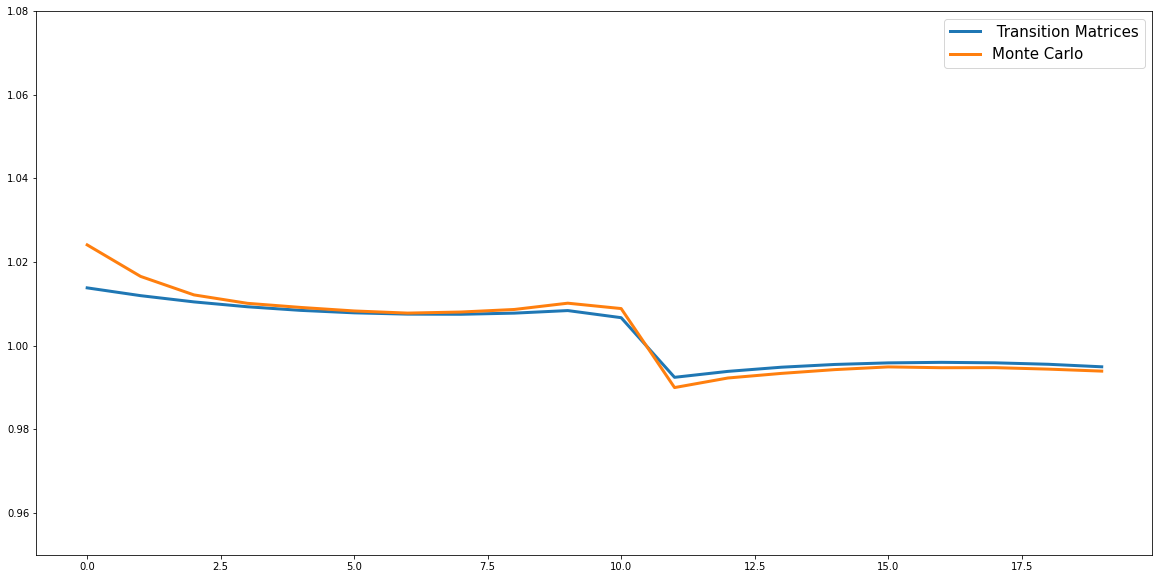

In [29]:

#plt.plot(AggC, label = 'without Harmenberg') #Without Neutral Measure
plt.plot(AggC_fast, label = ' Transition Matrices', linewidth = 3.0) #With Harmenberg Improvement
plt.plot(clvl, label = 'Monte Carlo', linewidth = 3.0) # Monte Carlo with Hamenberg Improvement
plt.legend(prop={'size': 15})
plt.ylim([.95,1.08])
plt.show()


### Path of Aggregate Assets given an anticipated interest rate shock at $t=10$


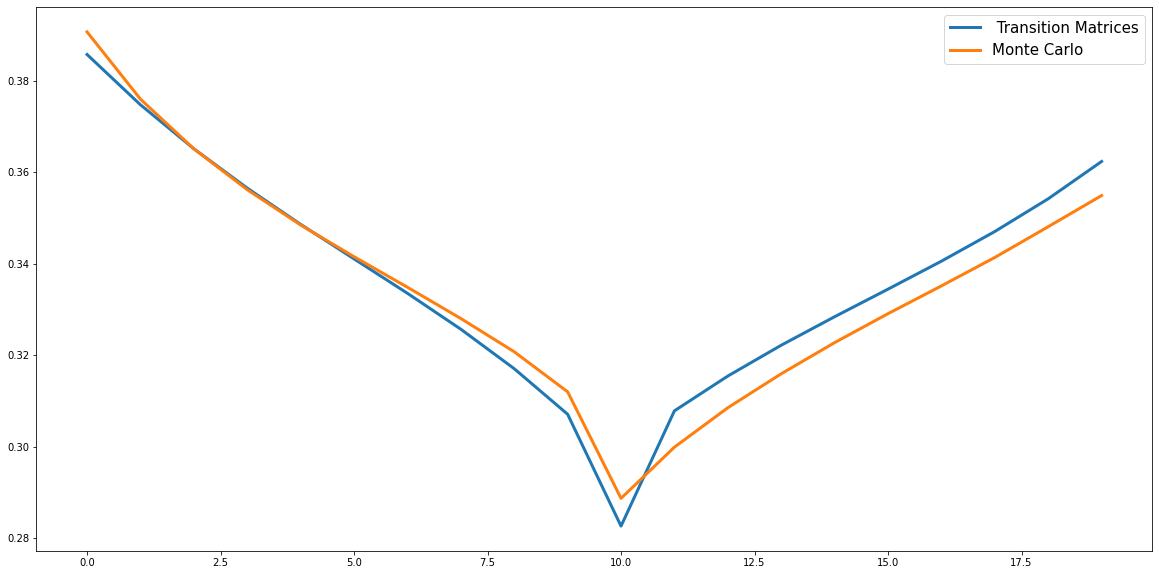

In [30]:
plt.plot(AggA_fast, label = ' Transition Matrices', linewidth = 3.0) #With Harmenberg Improvement
plt.plot(alvl, label = 'Monte Carlo', linewidth = 3.0)
plt.legend(prop={'size': 15})
plt.show()
